# Manipulating Taichung DE Power and Solar Irradiance

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Load data
Looking head 12 hours.

In [2]:
# quick look data 
power = pd.read_csv('data\power.csv', parse_dates=['Date'], index_col='Date')
solar = pd.read_csv('data\Solar_Irradiance.csv', parse_dates=['Date'], index_col='Date')
print(power.head(12))
print(solar.head(12))

                     power(KWH)
Date                           
2016-01-01 01:00:00         NaN
2016-01-01 02:00:00         NaN
2016-01-01 03:00:00         NaN
2016-01-01 04:00:00         NaN
2016-01-01 05:00:00         NaN
2016-01-01 06:00:00         NaN
2016-01-01 07:00:00         NaN
2016-01-01 08:00:00       146.0
2016-01-01 09:00:00       444.0
2016-01-01 10:00:00       680.0
2016-01-01 11:00:00       892.0
2016-01-01 12:00:00       932.0
                     Solar Irradiance
Date                                 
2016-01-01 06:00:00          4.164694
2016-01-01 07:00:00        107.933226
2016-01-01 08:00:00        305.363132
2016-01-01 09:00:00        477.315428
2016-01-01 10:00:00        621.637047
2016-01-01 11:00:00        664.687495
2016-01-01 12:00:00        623.537282
2016-01-01 13:00:00        574.049953
2016-01-01 14:00:00        468.611376
2016-01-01 15:00:00        278.413000
2016-01-01 16:00:00         92.779433
2016-01-01 17:00:00          4.196258


# Missing Data

Power data only records power > 0.

Solar data only record period 6:00-18:00.

Merge two data and fill 0.

In [3]:
# merge two data
data = power.merge(solar, on='Date', how='left')

# use 0 fill 
data.fillna(0, inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   power(KWH)        17544 non-null  float64
 1   Solar Irradiance  17544 non-null  float64
dtypes: float64(2)
memory usage: 411.2 KB
None


# Visualizing Data
Looking head fifteen days.

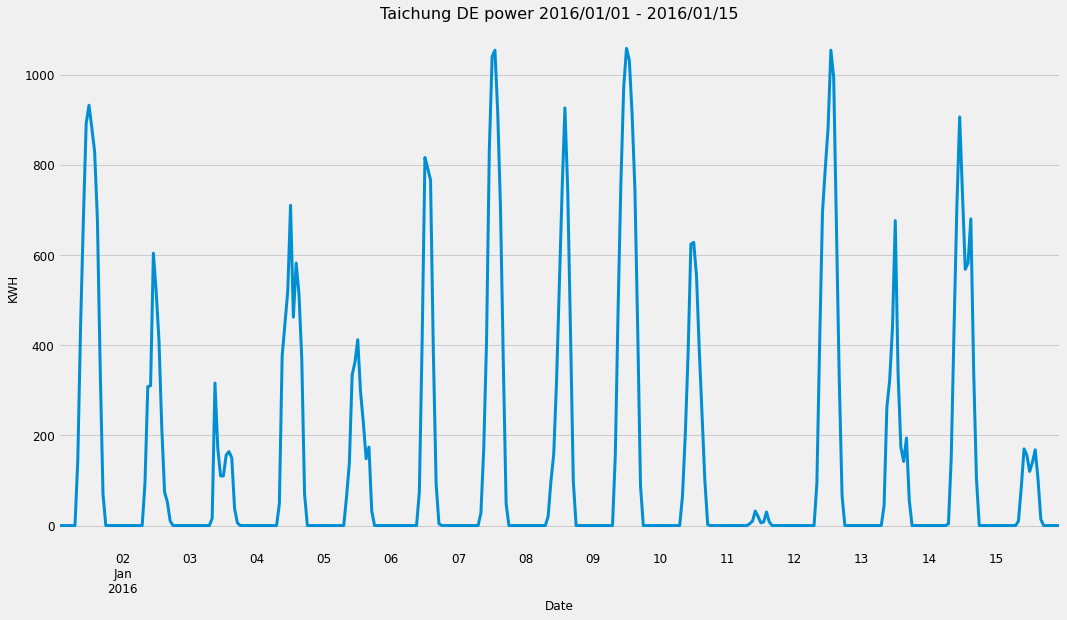

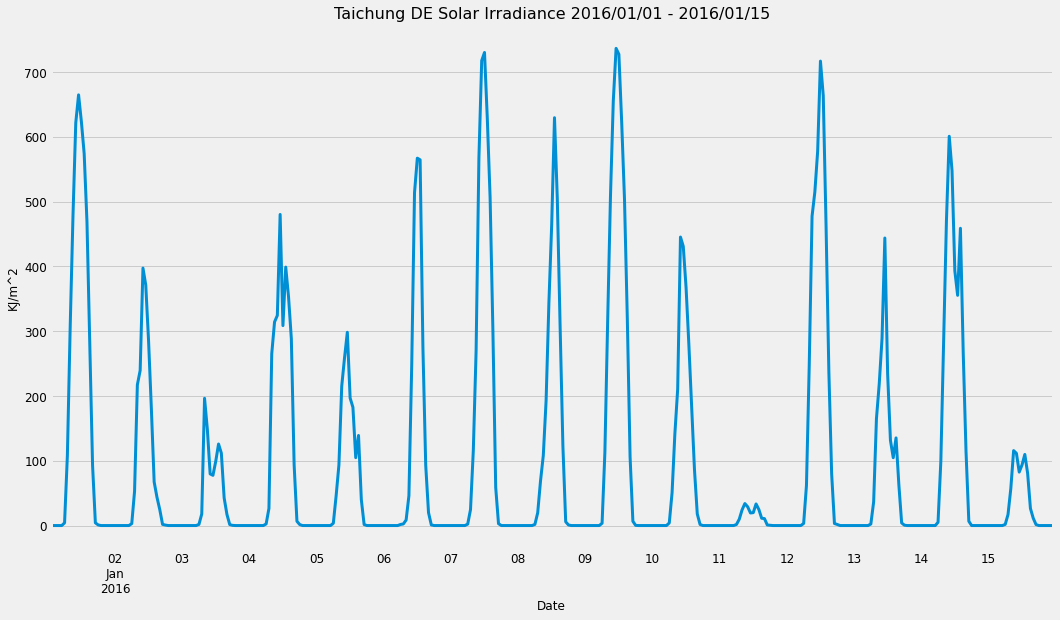

In [4]:
# Visualize head fifteen days
def visualize_head_fifteen(data, col, ylabel,title):
    ax = data.loc['2016-01-01':'2016/01/15',col].plot(figsize=(16,9), fontsize=12, linewidth=3, linestyle='-')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title,fontsize=16)
    plt.show()

visualize_head_fifteen(data, 'power(KWH)', 'KWH','Taichung DE power 2016/01/01 - 2016/01/15')
visualize_head_fifteen(data, 'Solar Irradiance', 'KJ/m^2','Taichung DE Solar Irradiance 2016/01/01 - 2016/01/15')

Aggregate every hour mean value.


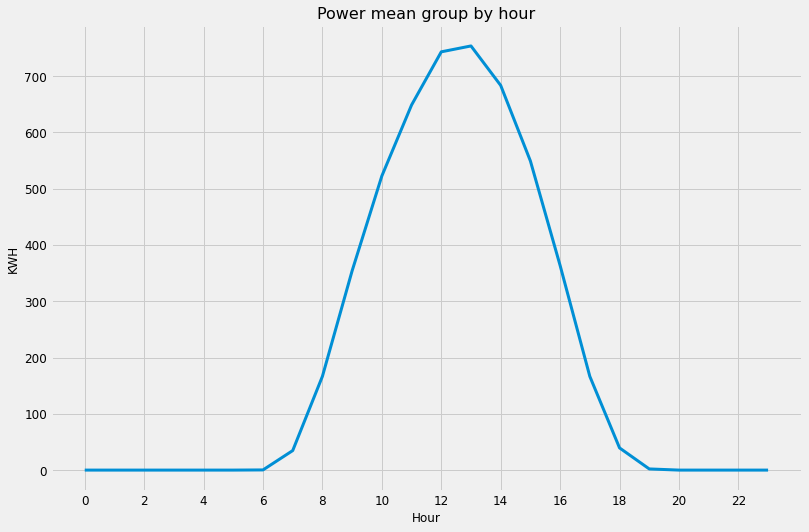

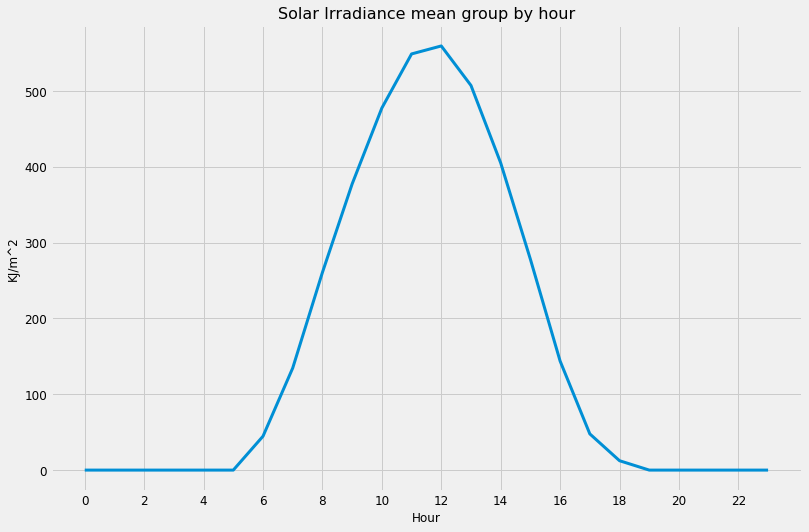

In [5]:
# aggregate every hour mean value
data['hour'] = data.index.hour
data_grouped_mean = data.groupby('hour').mean()

def visualize_group_mean(data_mean, col, y_label, title):
    ax = data_mean[col].plot(figsize=(12,8), fontsize=12, linewidth=3, linestyle='-',xticks=range(0,24,2))
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title,fontsize=16)
    plt.show()

visualize_group_mean(data_grouped_mean, 'power(KWH)', 'KWH', 'Power mean group by hour')
visualize_group_mean(data_grouped_mean, 'Solar Irradiance', 'KJ/m^2', 'Solar Irradiance mean group by hour')

Box plot group by hour. 

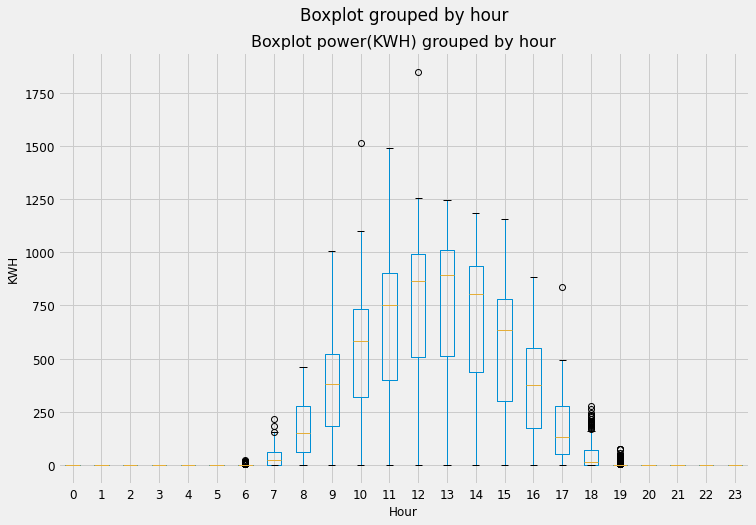

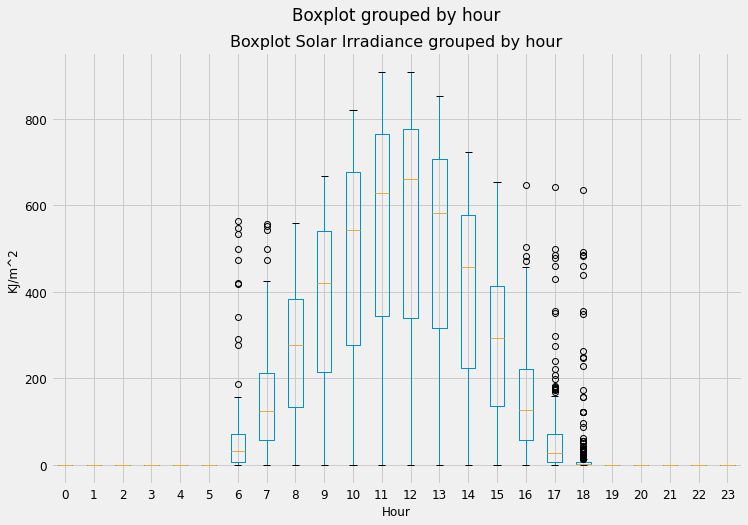

In [6]:
# box plot grouped by hour
def box_plot_hour(data, col, y_label, title):
    ax = data.boxplot(column=col, by='hour', figsize=(12,8), fontsize=12)
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title,fontsize=16)
    plt.show()

box_plot_hour(data, 'power(KWH)', 'KWH', "Boxplot power(KWH) grouped by hour")
box_plot_hour(data, 'Solar Irradiance', 'KJ/m^2', "Boxplot Solar Irradiance grouped by hour")

# Box Plot Outlier

$Q_{1}$ : first  quartile (25th percentile)

$Q_{3}$ : third  quartile (75th percentile)    

$ \Delta Q$ : interquartile  range (IQR) $Q_{3} - Q_{1}  $

$Upper = Q_{3} + 1.5 \times \Delta Q $

$Lower = Q_{1} - 1.5 \times \Delta Q $

Use upper or lower to replace outlier.

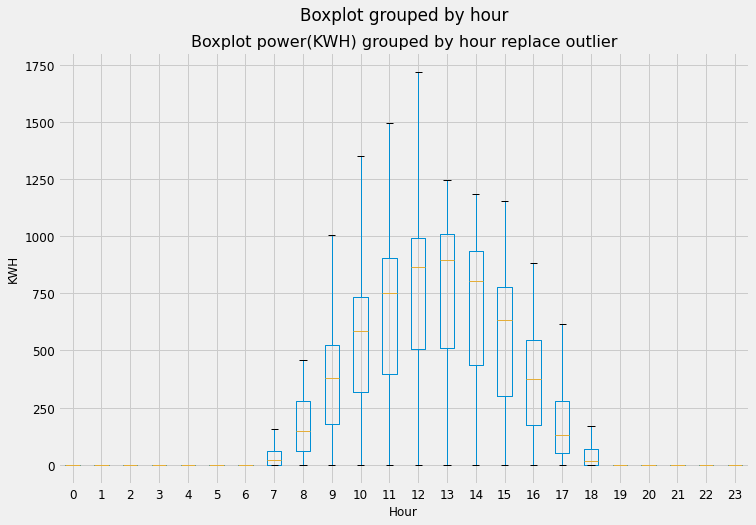

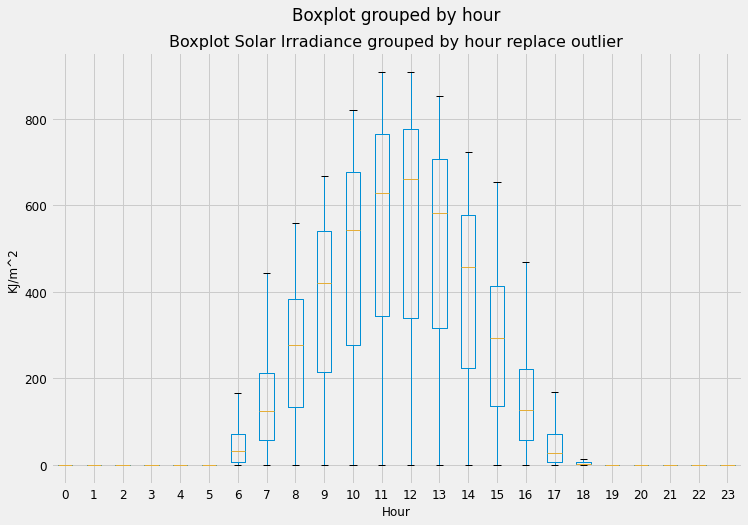

In [7]:
# replace outlier
def replace_outlier(series):
    Q1 = series.quantile(.25)
    Q3 = series.quantile(.75)
    IQR = (Q3-Q1)
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    series = np.where(series > upper, upper, np.where(series < lower, 
                      lower, series))
    return series

for i in range(6,20,1):
    hour_idx = (data.hour == i)
    power_hour = data.loc[hour_idx, ['power(KWH)']]
    solar_hour = data.loc[hour_idx, ['Solar Irradiance']]
    data.loc[hour_idx,['power(KWH)']] = replace_outlier(power_hour)
    data.loc[hour_idx,['Solar Irradiance']] = replace_outlier(solar_hour)

box_plot_hour(data, 'power(KWH)', 'KWH', "Boxplot power(KWH) grouped by hour replace outlier")
box_plot_hour(data, 'Solar Irradiance', 'KJ/m^2', "Boxplot Solar Irradiance grouped by hour replace outlier")

In [8]:
# drop hour column
data.drop(columns=['hour'], inplace=True)
# save as csv
data.to_csv('data\power_Solar_Irradiance.csv', encoding='utf-8-sig')